In [1]:
import sys
sys.path.append("../Python")
from array import array
import time
import numpy as np
import feather
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import os

# ML Tests
We load the *Pandas* version of a dataset from disk. Note that this is a bit of a shift in how a dataframe behaves!
By rounding the "true_e" parameter we undo the tiny variation introduced by writing and reading the data.

In [2]:
df = pd.read_feather("electrons_fiducial_cut_n1.feather")
df['true_e'] = df['true_e'].round(1)                       # Rounded version to one decimal.
ran_loc = np.random.permutation(len(df))                   # To randomize the entries in the data set.
df.iloc[ran_loc].head()

,energy,energy_cor,x,y,x_cor,y_cor,nhits,seed_e,seed_ix,seed_iy,true_e,score_e,score_x,score_y
22300,0.374550,0.441655,226.766556,37.972141,229.553299,37.272552,2,0.286890,14,2,0.5,0.477016,226.281446,37.886630
1606749,2.582965,2.902241,-117.618416,-47.253395,-121.806717,-45.829681,6,1.159067,-12,-2,3.0,2.967230,-121.074439,-47.343547
4055372,1.719609,1.898188,206.369125,43.789291,209.419220,43.165745,6,0.917668,13,2,2.0,1.985250,210.952288,44.673417
775979,3.401691,3.888012,59.397423,41.225639,59.408016,40.584133,8,2.228475,2,2,3.7,3.732113,57.838724,39.160722
1556047,2.999027,3.545016,-196.632401,80.967064,-203.504776,81.568970,6,2.123067,-18,5,3.5,3.469323,-202.144728,81.182758


## Plots
We can plot the variables against each other, but I don't think we learn a whole lot from this. Since we can only
plot a bit of the data this way, we do a random sample, which we stick in p_df.

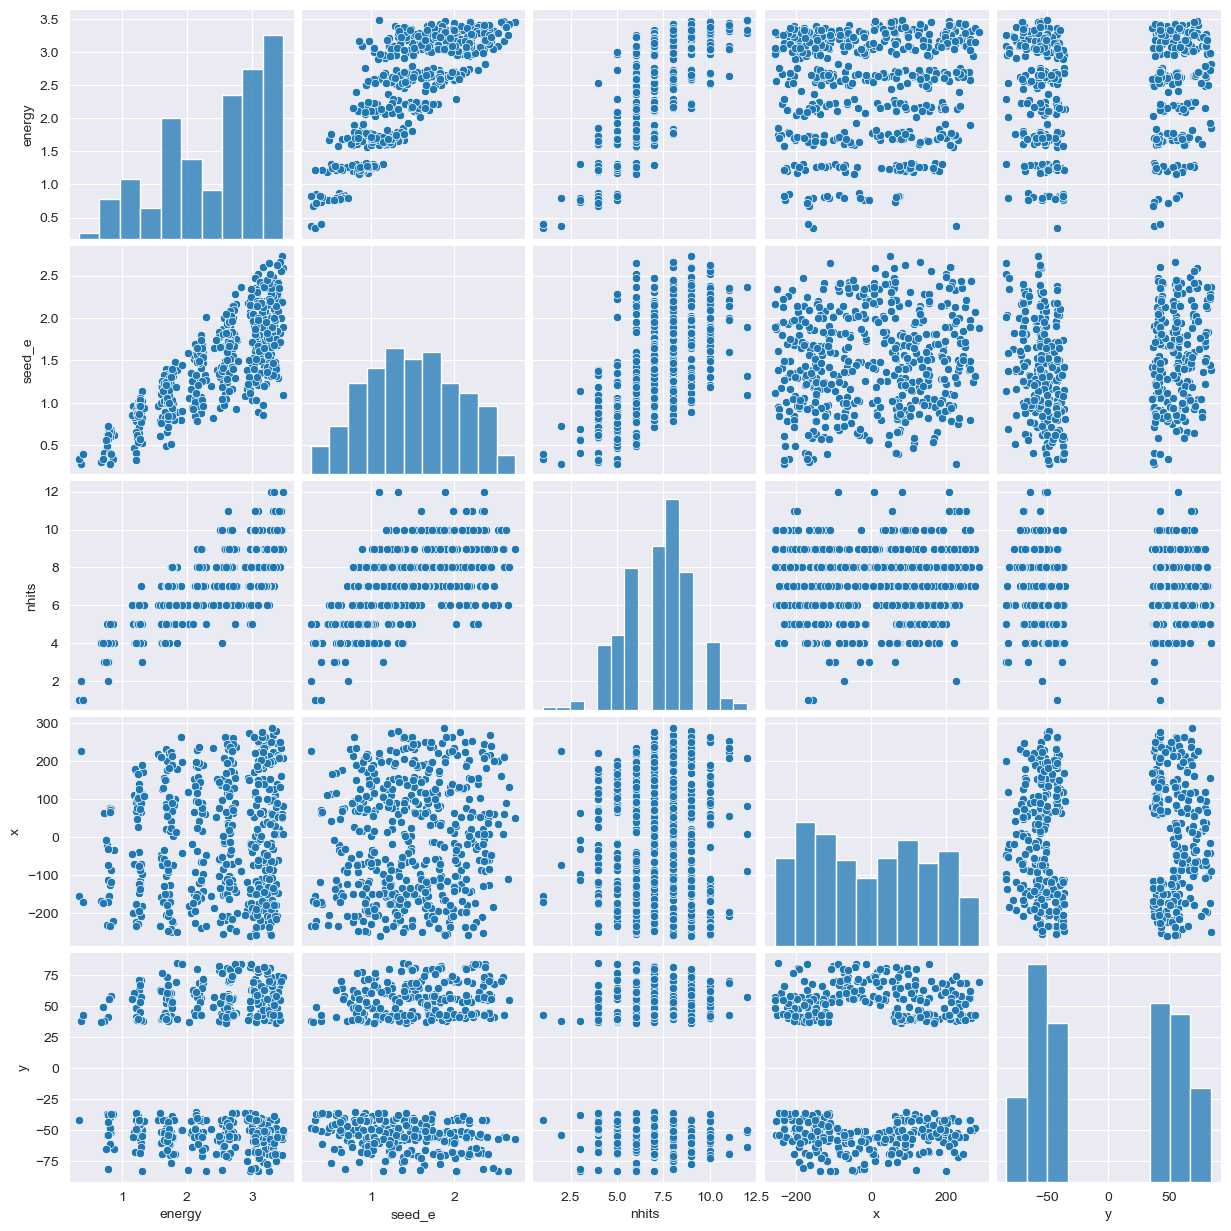

In [3]:
# Partial dataset
p_df = df.iloc[ran_loc[0:500]]
#df.iloc[locs][["energy","true_e","score_e","x","y"]]
sns.pairplot(p_df[["energy","seed_e","nhits","x","y"]])  # Grab some and plot against each other

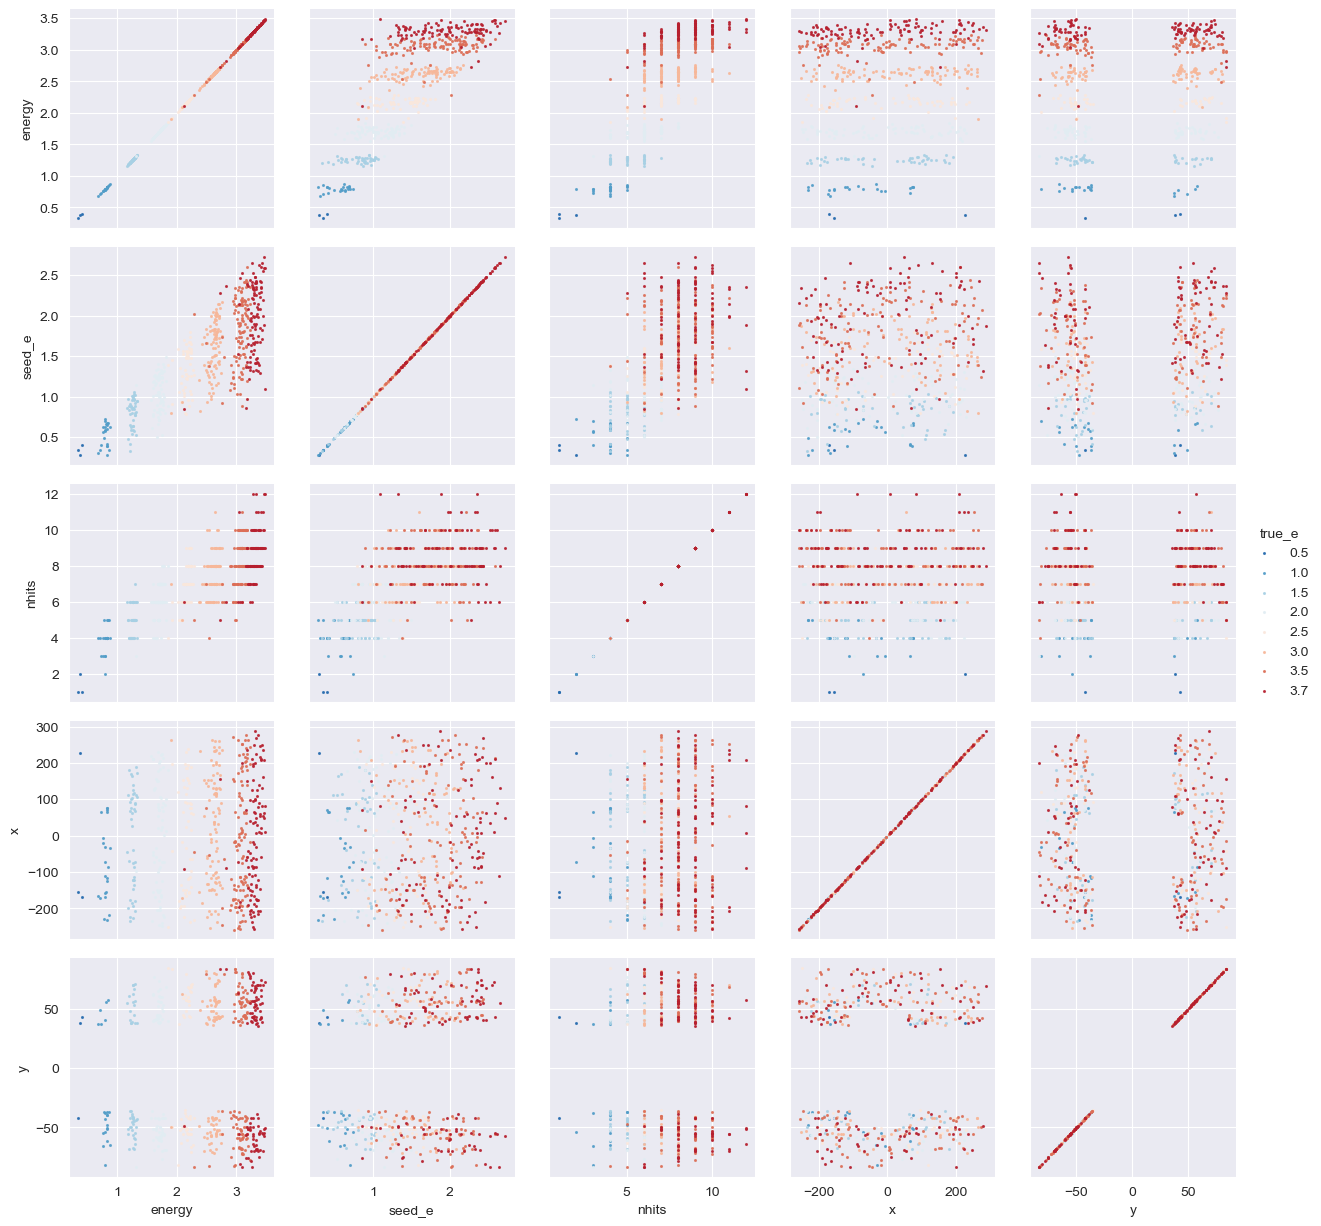

In [4]:
g = sns.PairGrid(p_df, vars=['energy', 'seed_e','nhits', 'x', 'y'], hue='true_e', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8, s=1.5)
g.add_legend();

# Try Pricipal Component Analysis
First we need to drop the prediction columns, (the Y) "true_e", "score_e", "score_x" and "score_y" from df.
We can also extend the data with the variables that were used by Andrea for his fits:
$$ f(E) = \frac{A}{E} + \frac{B}{\sqrt{E}} + C $$

In [5]:
df['one_over_e'] = 1/df['energy']
df['one_over_sqrt_e'] = 1/np.sqrt(df['energy'])
dfc = df.copy()
dfc = dfc.drop(columns=["true_e","score_e","score_x","score_y","seed_ix", "seed_iy","energy_cor","x_cor","y_cor"])

In [6]:
dfc.head()

,energy,x,y,nhits,seed_e,one_over_e,one_over_sqrt_e
0,2.218226,234.755005,-59.642876,7,1.158602,0.450811,0.671424
1,2.141741,10.951425,51.237640,6,1.218208,0.466910,0.683308
2,2.193644,69.209213,42.574310,6,1.061259,0.455863,0.675176
3,2.169153,53.537224,-55.714447,11,1.478549,0.461009,0.678977
4,2.222253,50.627842,72.618874,6,1.695154,0.449994,0.670816


In [8]:
pca = PCA()
XD = pca.fit_transform(dfc)
print("Transposed components. This way the *columns* read like the eigen vectors.")
pca.components_.T

Transposed components. This way the *columns* read like the eigen vectors.


array([[ 8.03847690e-04,  3.65150274e-05, -3.19120721e-01,
        -6.56243007e-01, -4.25345669e-01,  5.29239153e-01,
        -8.05817235e-02],
       [ 9.99998155e-01,  4.74478214e-04,  1.81768805e-03,
         3.93374277e-04,  1.54651862e-05,  7.68270818e-05,
        -3.29673041e-06],
       [-4.74579365e-04,  9.99999886e-01,  4.92009192e-05,
         2.80662872e-05,  1.92885311e-06, -2.24689444e-06,
         5.73622142e-08],
       [ 1.52304641e-03,  3.50488864e-05, -9.20535332e-01,
         3.84080396e-01,  6.67829704e-02, -2.51907001e-02,
        -3.06537676e-04],
       [ 5.77245103e-04,  2.40038440e-05, -1.85699055e-01,
        -5.90839654e-01,  7.45910494e-01, -2.45033185e-01,
         5.49985251e-04],
       [-3.57175883e-04, -1.12730219e-05,  1.09694646e-01,
         2.32982933e-01,  4.68047759e-01,  7.80605402e-01,
         3.24457101e-01],
       [-1.95349964e-04, -6.94118492e-06,  6.52403755e-02,
         1.35847950e-01,  1.97913935e-01,  2.23350140e-01,
        -9.4246155

In [9]:
pca.explained_variance_ratio_.reshape(1,7)

array([[8.81946298e-01, 1.17879699e-01, 1.57897250e-04, 1.18317638e-05,
        2.69362218e-06, 1.57200160e-06, 8.66710390e-09]])

### PCA Results
The PCA results state that two combinations of the input data explain 99% of variance in the data. Since these components are basically $x$ and $y$, it
is not clear if this is going to help us with our fits.

Quick test to make sure we understand what the output actually gives us:

In [10]:
row = 100
for i in range(len(XD[row])):
    print(f"{XD[row,i]:9.4f}, {np.dot((dfc.iloc[row,:] - pca.mean_),(pca.components_[i,:])):9.4f}, {pca.transform(dfc.iloc[row:row+1,:])[0,i]:9.4f}")

  10.3051,   10.3051,   10.3051
  60.5054,   60.5054,   60.5054
   2.4229,    2.4229,    2.4229
  -0.1191,   -0.1191,   -0.1191
  -0.1184,   -0.1184,   -0.1184
  -0.1272,   -0.1272,   -0.1272
   0.0099,    0.0099,    0.0099


In [11]:
XDdat = pd.DataFrame(XD, columns=[str(x) for x in range(len(XD[0]))])
XDdat['true_e'] = df['true_e']
df['diff_e'] = df['true_e'] - df['energy']
XDdat['diff_e'] = df['diff_e']


<Axes: xlabel='4', ylabel='diff_e'>

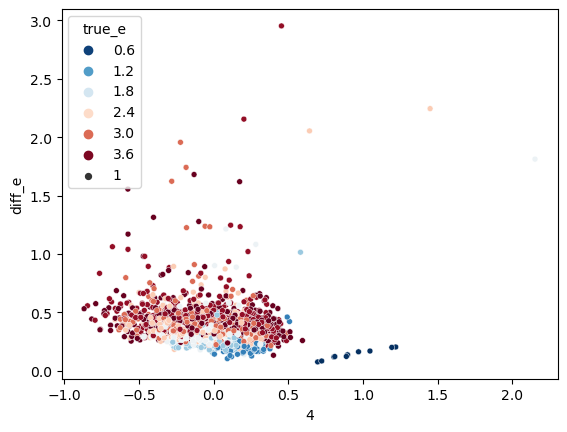

In [12]:
sns.scatterplot(XDdat.loc[ran_loc[0:2000]],x="4", y="diff_e", size = 1, hue='true_e', palette='RdBu_r')

<Axes: xlabel='energy', ylabel='diff_e'>

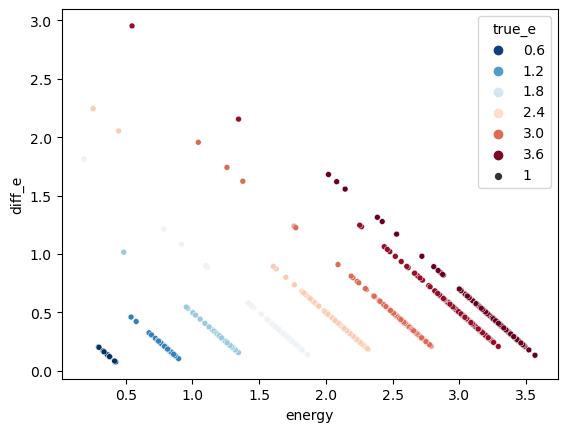

In [13]:
sns.scatterplot(df.loc[ran_loc[0:2000]],x="energy", y="diff_e", size = 1, hue='true_e', palette='RdBu_r')

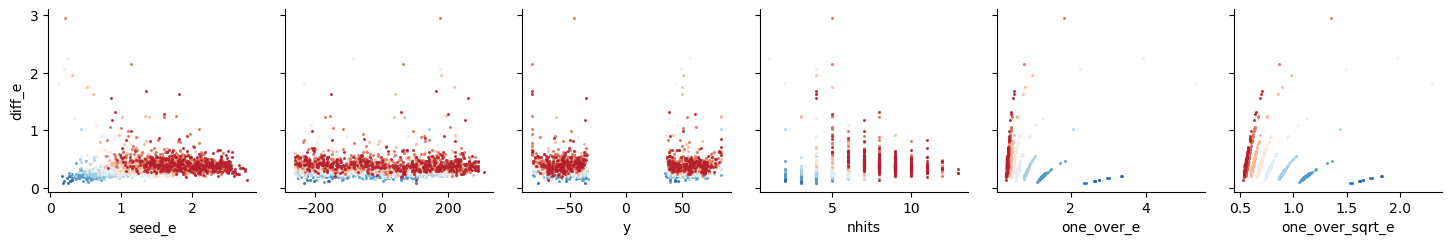

In [14]:
g = sns.PairGrid(df.loc[ran_loc[0:2000]], x_vars=['seed_e','x','y','nhits','one_over_e','one_over_sqrt_e'],y_vars=['diff_e'],hue='true_e', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8, s=1.5)

# Linear Regressions
We will try running the linear regressions from SkLearn over the data.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [8]:
dfc = df[["energy", "nhits", "seed_e", "one_over_e", "one_over_sqrt_e"]].copy()
dfy = df[['score_e']].copy()
linreg = LinearRegression()
#
# We need to split the data set into a "fit" set and a "validate" set.
# This needs to be done on the randomized locations in iloc.
split_frac = 0.5
split_point = int(len(ran_loc)*split_frac)
fit_loc = ran_loc[0:split_point]
val_loc = ran_loc[split_point:]
dfc_fit = dfc.iloc[fit_loc]
dfy_fit = dfy.iloc[fit_loc]
dfc_val = dfc.iloc[val_loc]
dfy_val = dfy.iloc[val_loc]
%time linreg.fit(dfc_fit,dfy_fit)
Ypred_fit = linreg.predict(dfc_fit)
Ypred_val = linreg.predict(dfc_val)
print(f"Mean square error fit         = {mean_squared_error(dfy_fit,Ypred_fit)}")
print(f"Mean square error validation  = {mean_squared_error(dfy_val,Ypred_val)}")
print("Coefficients:")
for i in range(len(linreg.coef_[0])):
    print(f"[{i:2d}] {linreg.feature_names_in_[i]:16s} * {linreg.coef_[0][i]:9.5f}")
print(f"         {' ':16s} {linreg.intercept_[0]}")

CPU times: user 169 ms, sys: 53.4 ms, total: 222 ms
Wall time: 211 ms
Mean square error fit         = 0.022140819455691272
Mean square error validation  = 0.02216624720889414
Coefficients:
[ 0] energy           *   1.06824
[ 1] nhits            *  -0.04107
[ 2] seed_e           *  -0.05122
[ 3] one_over_e       *   0.33122
[ 4] one_over_sqrt_e  *  -1.09662
                          1.1473700209688191


In [9]:
import ROOT as R

Welcome to JupyROOT 6.29/01


In [10]:
tmp_data = {key: df.iloc[fit_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_fit'] = Ypred_fit[:,0]
rdf_fit = R.RDF.FromNumpy(tmp_data)
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_fit'] = Ypred_val[:,0]
rdf_val = R.RDF.FromNumpy(tmp_data)

In [84]:
h1_true = rdf_fit.Histo1D(("h_true","True Energy;E [GeV]", 1000, 0., 4.),"true_e")
h1_clus = rdf_fit.Histo1D(("h_clus","Cluster Energy;E [GeV]", 1000, 0., 4.),"energy")
h1_clus_cor = rdf_fit.Histo1D(("h_clus_cor","Cluster Energy Cor;E [GeV]", 1000, 0., 4.),"energy_cor")
h1_fit = rdf_fit.Histo1D(("h_fit","Fit Energy;E [GeV]", 1000, 0., 4.),"energy_fit")
h1_df_clus = rdf_fit.Define("d","true_e - energy").Histo1D(("h_df_clus","Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5,0.8),"d")
h1_df_clus_cor = rdf_fit.Define("d","true_e - energy_cor").Histo1D(("h_df_clus_cor","Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2,0.8),"d")
h1_df_fit = rdf_fit.Define("d","true_e - energy_fit").Histo1D(("h_df_fit","Diff True - Fit E;#Delta E [GeV]", 1000, -0.5,0.8),"d")
h2_true = rdf_val.Histo1D(("h_true","True Energy;E [GeV]", 1000, 0., 4.),"true_e")
h2_clus = rdf_val.Histo1D(("h_clus","Cluster Energy;E [GeV]", 1000, 0., 4.),"energy")
h2_clus_cor = rdf_val.Histo1D(("h_clus_cor","Cluster Energy Cor;E [GeV]", 1000, 0., 4.),"energy_cor")
h2_fit = rdf_val.Histo1D(("h_fit","Fit Energy;E [GeV]", 1000, 0., 4.),"energy_fit")
h2_df_clus = rdf_val.Define("d","true_e - energy").Histo1D(("h_df_clus","Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5,0.8),"d")
h2_df_clus_cor = rdf_val.Define("d","true_e - energy_cor").Histo1D(("h_df_clus_cor","Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2,0.8),"d")
h2_df_fit = rdf_val.Define("d","true_e - energy_fit").Histo1D(("h_df_fit","Diff True - Fit E;#Delta E [GeV]", 1000, -0.5,0.8),"d")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc


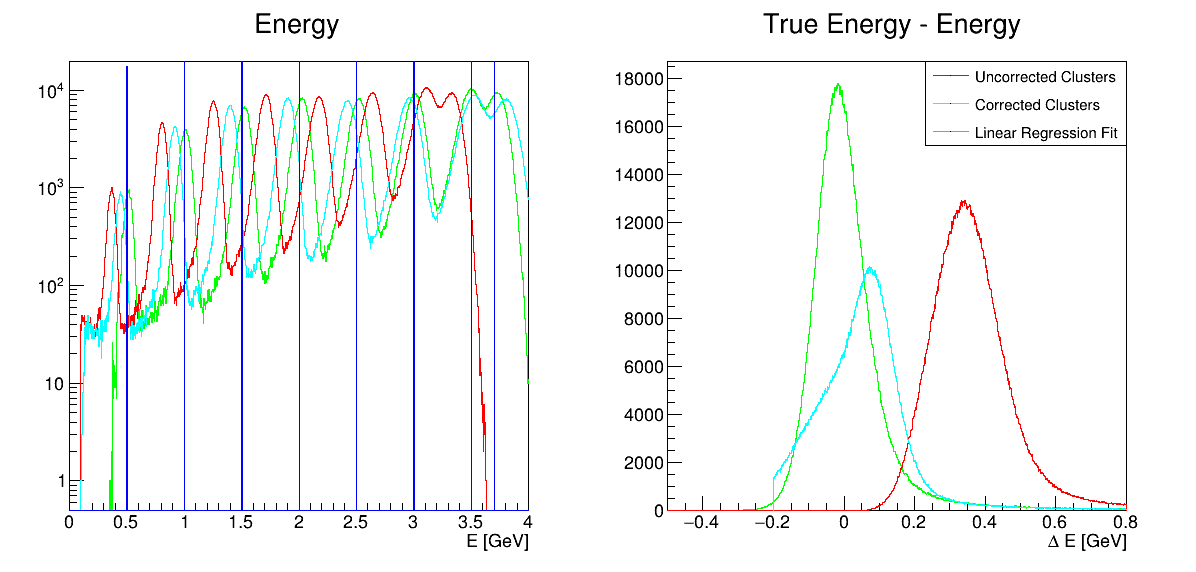

In [86]:
cc = R.TCanvas("cc","CC",1200,600)
cc.Divide(2,1)
p1 = cc.cd(1)
p1.SetLogy()
h2_clus.SetLineColor(R.kRed)
h2_clus_cor.SetLineColor(R.kCyan)
h2_fit.SetLineColor(R.kGreen)
h2_fit.SetStats(0)
h2_fit.SetTitle("Energy")
h2_fit.Draw()
h2_clus.Draw("same")
h2_clus_cor.Draw("same")
h2_true.SetLineColor(R.kBlue)
h2_true.Draw("same")
p2 = cc.cd(2)
h2_df_clus.SetLineColor(R.kRed)
h2_df_clus_cor.SetLineColor(R.kCyan)
h2_df_fit.SetLineColor(R.kGreen)
h2_df_fit.SetStats(0)
h2_df_fit.SetTitle("True Energy - Energy")
h2_df_fit.Draw()
h2_df_clus.Draw("same")
h2_df_clus_cor.Draw("same")
leg0_p2 = R.TLegend(0.55,0.75,0.9,0.9)
leg0_p2.AddEntry(h2_df_clus.GetPtr(),"Uncorrected Clusters")
leg0_p2.AddEntry(h2_df_clus_cor.GetPtr(),"Corrected Clusters")
leg0_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression Fit")
leg0_p2.Draw()
cc.Draw()

In [13]:
# Number of entries in each histogram.
print(h2_df_clus.GetEntries(), h2_df_clus_cor.GetEntries(), h2_df_fit.GetEntries())

2436666.0 2436666.0 2436666.0


## Going to higher order polynomial fit.
We can go to cubic polynomial combinations of the variables, and trying to be careful to weed out obvious trouble parameters. This does not seem to buy us any improvement in the fit. It appears that higher order terms do not help.

In [47]:
pol_feature = PolynomialFeatures(degree=3, include_bias=False)
tmp = pol_feature.fit_transform(dfc_fit)
dfc_fit_pol = pd.DataFrame(tmp, columns=pol_feature.get_feature_names_out())
dfc_fit_pol.drop(columns=['energy one_over_e','energy^2 one_over_e','one_over_sqrt_e^2','energy^2 one_over_e',
                          'energy nhits one_over_e','energy seed_e one_over_e', 'energy seed_e one_over_sqrt_e',
                          'energy one_over_e^2', 'energy one_over_e one_over_sqrt_e','energy one_over_sqrt_e^2',
                          'nhits one_over_sqrt_e^2', 'seed_e one_over_sqrt_e^2', 'one_over_e one_over_sqrt_e^2',
                          'one_over_sqrt_e^3', 'energy one_over_sqrt_e','energy^2 one_over_sqrt_e',
                          'energy nhits one_over_sqrt_e','one_over_e one_over_sqrt_e'], inplace=True)
tmp = pol_feature.fit_transform(dfc_val)
dfc_val_pol = pd.DataFrame(tmp, columns=pol_feature.get_feature_names_out())
dfc_val_pol.drop(columns=['energy one_over_e','energy^2 one_over_e','one_over_sqrt_e^2','energy^2 one_over_e',
                          'energy nhits one_over_e','energy seed_e one_over_e', 'energy seed_e one_over_sqrt_e',
                          'energy one_over_e^2', 'energy one_over_e one_over_sqrt_e','energy one_over_sqrt_e^2',
                          'nhits one_over_sqrt_e^2', 'seed_e one_over_sqrt_e^2', 'one_over_e one_over_sqrt_e^2',
                          'one_over_sqrt_e^3', 'energy one_over_sqrt_e', 'energy^2 one_over_sqrt_e',
                          'energy nhits one_over_sqrt_e','one_over_e one_over_sqrt_e'], inplace=True)
linreg_pol = LinearRegression()
%time linreg_pol.fit(dfc_fit_pol,dfy_fit)
Ypred_fit_pol = linreg_pol.predict(dfc_fit_pol)
Ypred_val_pol = linreg_pol.predict(dfc_val_pol)
print(f"Mean square error for fit        = {mean_squared_error(dfy_fit,Ypred_fit)}")
print(f"Mean square error for validation = {mean_squared_error(dfy_val,Ypred_val)}")
for i in range(len(linreg_pol.coef_[0])):
    print(f"[{i:2d}] {linreg_pol.feature_names_in_[i]:16s} * {linreg_pol.coef_[0][i]:9.5f}")
print(f"         {' ':16s} {linreg_pol.intercept_[0]}")

CPU times: user 3.12 s, sys: 395 ms, total: 3.52 s
Wall time: 1.78 s
Mean square error for fit        = 0.022117349097957782
Mean square error for validation = 0.022189368943302073
[ 0] energy           * -10.79845
[ 1] nhits            *   1.97274
[ 2] seed_e           * -12.33910
[ 3] one_over_e       *  26.85283
[ 4] one_over_sqrt_e  * -53.89437
[ 5] energy^2         *   3.71112
[ 6] energy nhits     *  -0.77097
[ 7] energy seed_e    *  -0.16405
[ 8] nhits^2          *   0.22328
[ 9] nhits seed_e     *  -0.04067
[10] nhits one_over_e *   1.69695
[11] nhits one_over_sqrt_e *  -2.89286
[12] seed_e^2         *   2.53051
[13] seed_e one_over_e * -44.64090
[14] seed_e one_over_sqrt_e *  38.41954
[15] one_over_e^2     *  -5.38286
[16] energy^3         *  -0.51158
[17] energy^2 nhits   *   0.12957
[18] energy^2 seed_e  *   0.14870
[19] energy nhits^2   *  -0.02459
[20] energy nhits seed_e *   0.04391
[21] energy seed_e^2  *  -0.25643
[22] nhits^3          *  -0.00163
[23] nhits^2 seed_e   

In [49]:
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_pol_fit'] = Ypred_val_pol[:,0]
rdf_pol = R.RDF.FromNumpy(tmp_data)

In [51]:
h3_fit = rdf_pol.Histo1D(("h3_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_pol_fit")
h3_df_fit = rdf_pol.Define("d", "true_e - energy_pol_fit").Histo1D(
    ("h3_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc


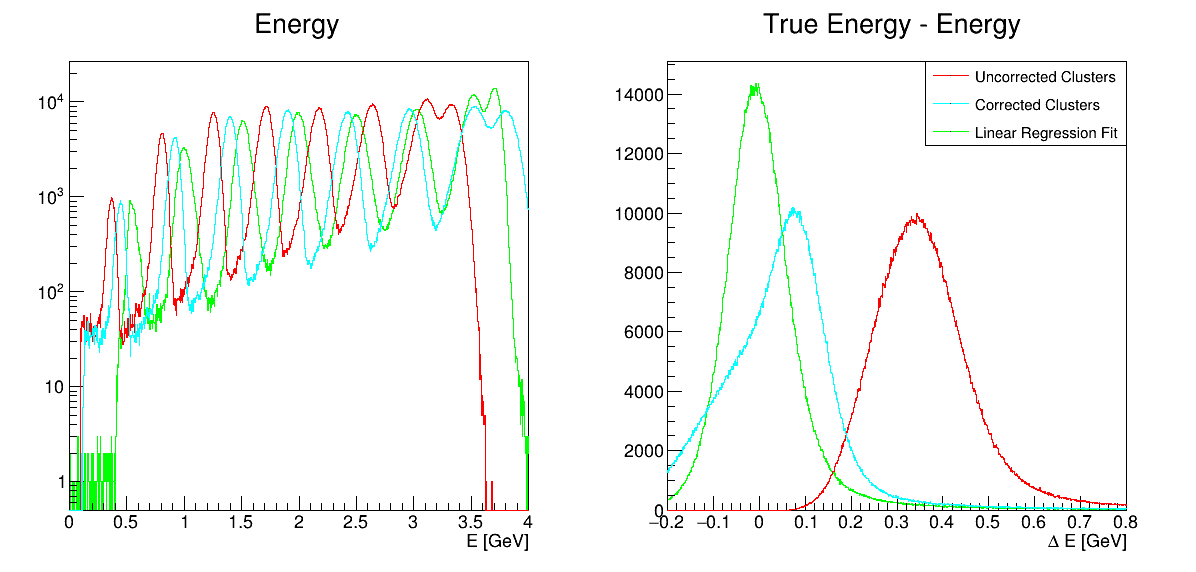

In [52]:
cc = R.TCanvas("cc","CC",1200,600)
cc.Divide(2,1)
p1 = cc.cd(1)
p1.SetLogy()
#h_true.SetLineColor(R.kBlue)
#h_true.Draw()
h2_clus.SetLineColor(R.kRed)
h2_clus_cor.SetLineColor(R.kCyan)
h3_fit.SetLineColor(R.kGreen)
h3_fit.SetStats(0)
h3_fit.SetTitle("Energy")
h3_fit.Draw()
h2_clus.Draw("same")
h2_clus_cor.Draw("same")
p2 = cc.cd(2)
h2_df_clus.SetLineColor(R.kRed)
h2_df_clus_cor.SetLineColor(R.kCyan)
h3_df_fit.SetLineColor(R.kGreen)
h3_df_fit.SetStats(0)
h3_df_fit.SetTitle("True Energy - Energy")
h3_df_fit.Draw()
h2_df_clus.Draw("same")
h2_df_clus_cor.Draw("same")
leg0_p2 = R.TLegend(0.55,0.75,0.9,0.9)
leg0_p2.AddEntry(h2_df_clus.GetPtr(),"Uncorrected Clusters")
leg0_p2.AddEntry(h2_df_clus_cor.GetPtr(),"Corrected Clusters")
leg0_p2.AddEntry(h3_df_fit.GetPtr(),"Linear Regression Fit")
leg0_p2.Draw()
cc.Draw()

# Going to a Neural Network
So then the next level up would be to construct something that behaves more like a neural network. The first step would be to
create a neural network that essentially replicates the linear fit we already did.

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(f"Tensorflow version: {tf.__version__}")
weights_store = [[np.array([[[1.0756719]],[[-0.04075409]],[[-0.05301237]],[[0.29785597]],[[-1.011633]],]), np.array([1.088990569114685])]]

Tensorflow version: 2.9.0


In [44]:
model = keras.Sequential([
    layers.Dense(units=1,activation="linear", input_shape=(5,),
                 kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.1,stddev=0.01),
                 bias_initializer=tf.keras.initializers.Zeros())
])
model.compile(
    # optimizer=tf.optimizers.SGD(learning_rate=0.000001),
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss="mse" # tf.keras.losses.MeanSquaredError() # alternate: 'mean_absolute_error'='mae', 'mean_squared_error' = 'mse'
)

In [45]:
model.set_weights(weights_store[-1])
#weights = model.get_weights()
#print(weights)

[array([[ 1.073357  ],
       [-0.03984765],
       [-0.05181863],
       [ 0.29512534],
       [-1.0057888 ]], dtype=float32), array([1.0888693], dtype=float32)]


In [49]:
history = model.fit(dfc_fit, dfy_fit,  verbose=1, epochs=1)

76146/76146 [==============================] - 277s 4ms/step - loss: 0.0222


In [73]:
# Ypred_val_NN1 =  model.predict(dfc_val)  ## !! This is *very* slow evaluating on my Mac.
weights = model.get_weights()
Ypred_fit_NN1 = np.dot(dfc_fit, weights[0]) + weights[1][0]
Ypred_val_NN1 = np.dot(dfc_val, weights[0]) + weights[1][0]
print(f"Final value for the loss         = {history.history['loss'][-1]}")
print(f"Mean square error for the fit    = {mean_squared_error(Ypred_fit_NN1, dfy_fit)}")
print(f"Mean square error for validation = {mean_squared_error(Ypred_val_NN1, dfy_val)}")
print("Weights = ")
print("[np.array([", end="")
for i in range(len(weights[0])):
    print(f"[{weights[0][i]}],", end="")
print(f"]), np.array([{weights[1][0]}])]")
weights_store.append(weights)

Final value for the loss         = 0.022158624604344368
Mean square error for the fit    = 0.022145226464720707
Mean square error for validation = 0.022174029170779156
Weights = 
[np.array([[[1.0756719]],[[-0.04075409]],[[-0.05301237]],[[0.29785597]],[[-1.011633]],]), np.array([1.088990569114685])]


In [79]:
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_NN1'] = Ypred_val_NN1[:,0]
rdf_NN1 = R.RDF.FromNumpy(tmp_data)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc4


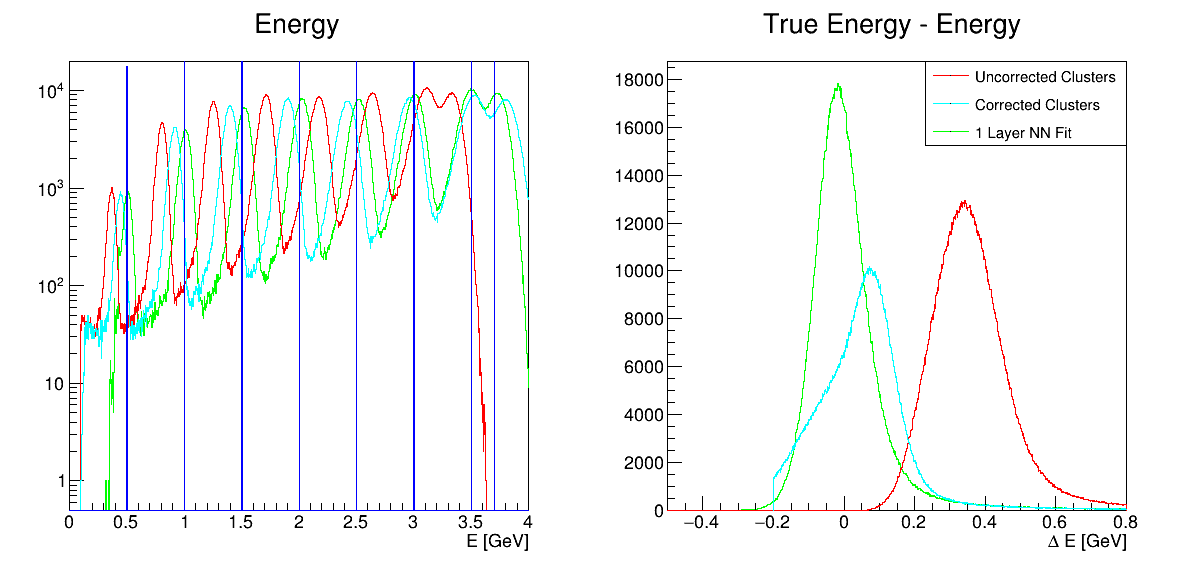

In [83]:
h4_true = rdf_NN1.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h4_clus = rdf_NN1.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h4_clus_cor = rdf_NN1.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h4_fit = rdf_NN1.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN1")
h4_df_clus = rdf_NN1.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h4_df_clus_cor = rdf_NN1.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h4_df_fit = rdf_NN1.Define("d", "true_e - energy_NN1").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc4 = R.TCanvas("cc4", "CC4", 1200, 600)
cc4.Divide(2, 1)
p1 = cc4.cd(1)
p1.SetLogy()
h4_clus.SetLineColor(R.kRed)
h4_clus_cor.SetLineColor(R.kCyan)
h4_fit.SetLineColor(R.kGreen)
h4_fit.SetStats(0)
h4_fit.SetTitle("Energy")
h4_fit.Draw()
h4_clus.Draw("same")
h4_clus_cor.Draw("same")
h4_true.SetLineColor(R.kBlue)
h4_true.Draw("same")
p2 = cc4.cd(2)
h4_df_clus.SetLineColor(R.kRed)
h4_df_clus_cor.SetLineColor(R.kCyan)
h4_df_fit.SetLineColor(R.kGreen)
h4_df_fit.SetStats(0)
h4_df_fit.SetTitle("True Energy - Energy")
h4_df_fit.Draw()
h4_df_clus.Draw("same")
h4_df_clus_cor.Draw("same")
leg4_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg4_p2.AddEntry(h4_df_clus.GetPtr(), "Uncorrected Clusters")
leg4_p2.AddEntry(h4_df_clus_cor.GetPtr(), "Corrected Clusters")
leg4_p2.AddEntry(h4_df_fit.GetPtr(), "1 Layer NN Fit")
leg4_p2.Draw()
cc4.Draw()